In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from networkx.algorithms.community import girvan_newman
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import random

import torch
import torch.nn as nn
from torch.optim import SGD

# Задача 2.


**ФИО**: Иванченко Анастасия Александровна

**Группа**: S4201

Список выполненных пунктов задания:

- [+] Найти набор данных для бинарной классификации рёбер в графе.
- [+] Реализовать случайные блуждания алгоритма `DeepWalk` и построить множества схожих вершин
- [+] Обучить эмбеддинги вершин, используя `SGD` и **negative sampling**.
- [+] Визуализировать эмбеддинги.
- [+] (+5 баллов) Также реализовать `node2vec` блуждания и обучить классификатор, используя его. Сравнить результаты.


# Данные

**Поля:**

Каждая строка данного файла представляет собой граф с:

`node_feat`: узлы

`edge_index`: пары узлов, образующих ребра

`edge_attr` (список: #ребра x #элементы-ребра): для вышеупомянутых ребер содержит их элементы

`y` : содержит количество меток, доступных для прогнозирования (здесь 1, равно нулю или единице)

`num_nodes` : количество узлов графа


**Краткое описание набора данных**
Набор данных по СПИДу - это набор данных, содержащий соединения, проверенные на наличие признаков активности против ВИЧ.

Ссылка на данные: https://huggingface.co/datasets/graphs-datasets/AIDS

In [2]:
df = pd.read_parquet("hf://datasets/graphs-datasets/AIDS/data/full-00000-of-00001-2a1e5fb28f54a227.parquet")
df.head()

,edge_index,node_feat,edge_attr,y,num_nodes
0,"[[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, ...",[0],47
1,"[[0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5,...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...",[1],11
2,"[[0, 0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 7,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, ...",[1],9
3,"[[0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 6, 7,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, ...",[1],10
4,"[[0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, ...",[0],16


In [3]:
def get_one_graph(df: pd.DataFrame) -> list[nx.Graph]:
    """
    Получим один граф из набора данных
    """
    list_weighted_grah = [(start_node, end_node) 
                        for start_node, end_node in zip(
                            df['edge_index'][0], 
                            df['edge_index'][1]
                            )]
    
    G = nx.Graph(list_weighted_grah)
    return G

In [4]:
# выберем граф с максимальным количеством вершин
df[df['num_nodes'].max() == df['num_nodes']]

,edge_index,node_feat,edge_attr,y,num_nodes
453,"[[0, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 5, 6, 6, 7,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...",[0],94
1055,"[[0, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 5, 6, 6, 7,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...",[0],94
1601,"[[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, ...",[0],94


In [5]:
G = get_one_graph(df.iloc[1055])

# Визуализация

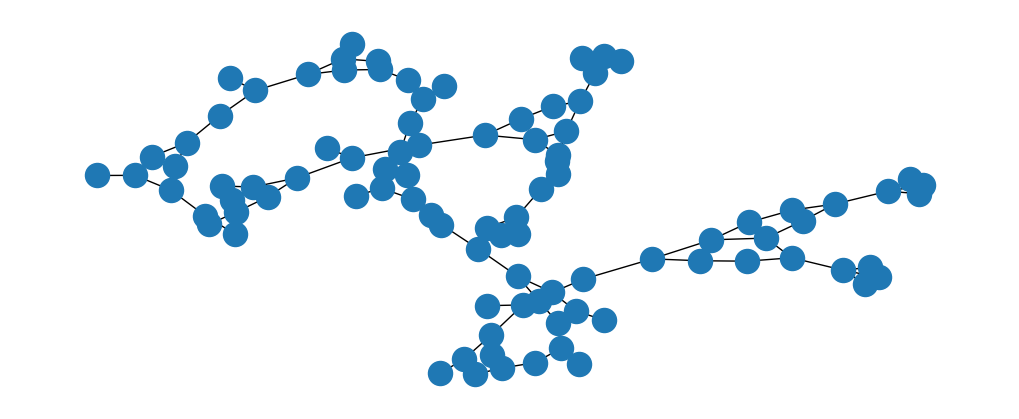

In [6]:
plt.figure(figsize=(10, 4))
nx.draw(G, with_labels=False)
plt.show()

Так как граф не имеет бинарных меток для каждой вершины. Воспользуемся методом кластеризации для разделения графа на сообщества(группы).

Используем алгоритм алгоритм Гирван — Ньюмена — иерархический метод, используемый для обнаружения структур сообществ в сложных системах. 

Алгоритм Гирвана–Ньюмана обнаруживает сообщества путем постепенного удаления ребер из исходного графика. Алгоритм удаляет “наиболее ценное” ребро, традиционно ребро с наибольшей центральностью между ними, на каждом шаге. Когда график разбивается на части, обнажается тесно связанная структура сообщества, и результат может быть изображен в виде дендрограммы.

In [7]:
com = next(girvan_newman(G))
g1, g2 = tuple(com)

Размер сообщества 1: 46, Размер сообщества 2: 48


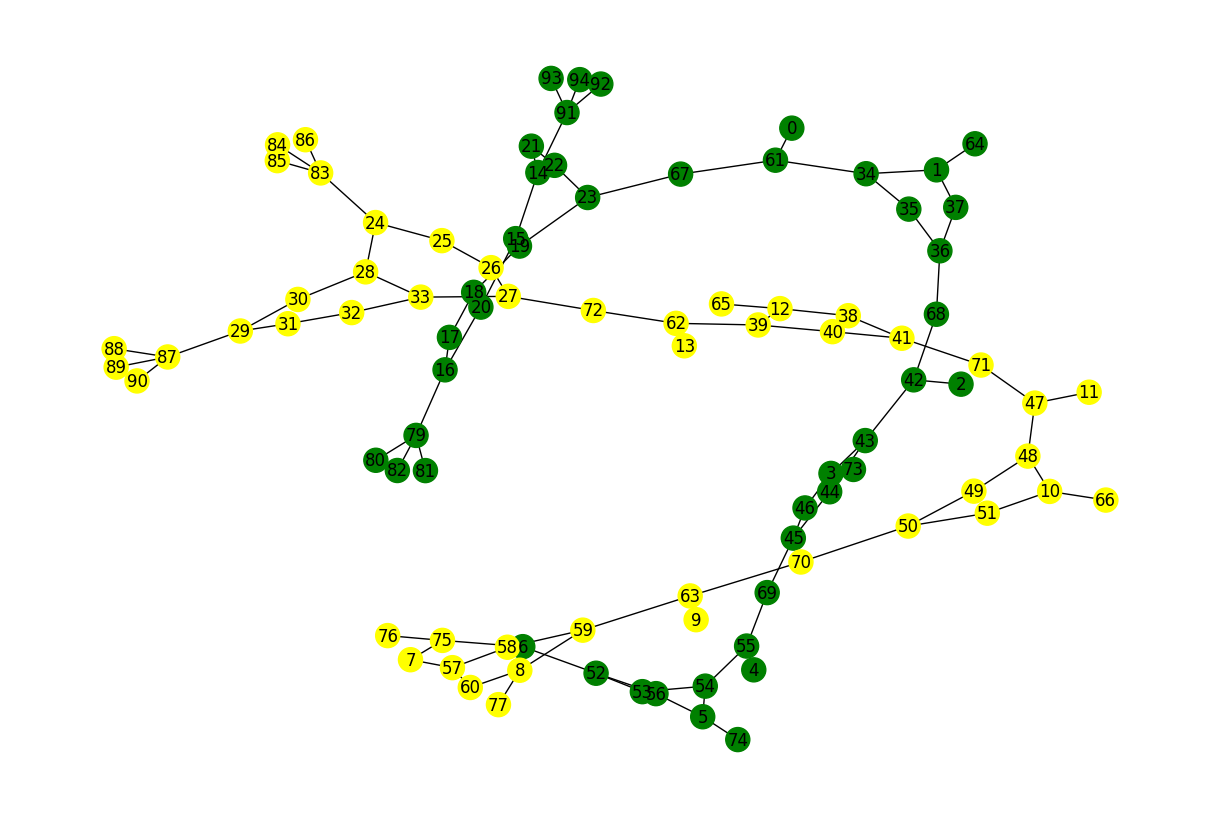

In [9]:
print(f"Размер сообщества 1: {len(g1)}, Размер сообщества 2: {len(g2)}")

plt.figure(figsize=(12, 8))
colors = {node: "green" if node in g1 else "yellow" for node in G}
nx.draw(G, with_labels=True, node_color=colors.values(), node_size=300)
plt.show()

In [10]:
def random_walks_graph(G: nx.Graph,
                          num_walks: int,
                          walk_length: int):
    """
    Генерация случайного блуждания по графу.
    На заданную длину walk_length и число проходов num_walks.
    """
    all_walks = []

    for node in G.nodes():
        for _ in range(num_walks):
            one_walk = [node]
            for _ in range(0, walk_length - 1):
                neighbors = list(G.neighbors(node))
                if len(neighbors) > 0:
                    random_neighbor = np.random.choice(neighbors)
                    one_walk.append(random_neighbor)
                    node = random_neighbor
                else:
                    break
            all_walks.append(one_walk)

    return all_walks

In [11]:
num_walks = 8
walk_length = 16 
walks = random_walks_graph(G, num_walks, walk_length)

# Посмотрим на несколько полученных путей
for i, walk in enumerate(walks[:10]):
    print(f"Walk {i}: {walk}")

Walk 0: [0, 61, 34, 35, 34, 61, 67, 23, 19, 15, 14, 15, 19, 23, 22, 23]
Walk 1: [23, 67, 61, 0, 61, 67, 23, 22, 23, 22, 23, 67, 23, 67, 23, 19]
Walk 2: [19, 15, 19, 23, 22, 21, 22, 23, 22, 23, 67, 23, 67, 61, 0, 61]
Walk 3: [61, 0, 61, 34, 61, 0, 61, 34, 35, 34, 35, 34, 1, 64, 1, 34]
Walk 4: [34, 35, 34, 61, 34, 1, 64, 1, 34, 1, 37, 1, 64, 1, 34, 1]
Walk 5: [1, 64, 1, 37, 1, 64, 1, 34, 1, 37, 36, 37, 1, 34, 61, 34]
Walk 6: [34, 1, 64, 1, 37, 36, 35, 34, 61, 34, 61, 67, 23, 67, 23, 19]
Walk 7: [19, 18, 17, 18, 19, 15, 20, 16, 79, 16, 20, 15, 20, 15, 19, 15]
Walk 8: [61, 0, 61, 34, 35, 36, 37, 36, 35, 36, 37, 1, 34, 35, 34, 1]
Walk 9: [1, 64, 1, 34, 1, 34, 61, 0, 61, 0, 61, 0, 61, 34, 35, 34]


In [12]:
def sample_negative_edges(G, g1, g2, num_neg_samples):
  """
  Генерируем несуществующие связи между группами.
  И ребра к-х нет в графе.
  """

  neg_edge_list = []
  pos_set = set(G.edges())

  while len(neg_edge_list) < num_neg_samples:
    u, v = np.random.choice(G.nodes(), 2)
    if u == v or (u, v) in pos_set or (v, u) in pos_set:
            continue
    if (u, v) in neg_edge_list or (v, u) in neg_edge_list:
            continue
    if (u in g1 and v in g2) or (u in g2 and v in g1):
          neg_edge_list.append((u, v))
    else:
        neg_edge_list.append((u, v))
  return neg_edge_list

In [13]:
def edge_list_to_tensor(edge_list, node_to_index):
	edge_index = torch.zeros(2, len(edge_list), dtype=torch.long)
  
	for i, (u, v) in enumerate(edge_list):
		edge_index[0][i] = node_to_index[u]
		edge_index[1][i] = node_to_index[v]

	return edge_index

In [14]:
# конфертируем имена вершин в индексы
node_to_index = {node: i for i, node in enumerate(G.nodes())}

pos_edge_list = [(u, v) for u, v in G.edges() if (u in g1 and v in g1) or (u in g2 and v in g2)]
neg_edge_list = sample_negative_edges(G, g1, g2, len(pos_edge_list))

pos_edge_index = edge_list_to_tensor(pos_edge_list, node_to_index)
neg_edge_index = edge_list_to_tensor(neg_edge_list, node_to_index)

In [15]:
print(f"Тензор положительных рёбер имеет форму {pos_edge_index.shape}")
print(f"Тензор отрицательных рёбер имеет форму {neg_edge_index.shape}")

Тензор положительных рёбер имеет форму torch.Size([2, 102])
Тензор отрицательных рёбер имеет форму torch.Size([2, 102])


In [17]:
def visualize_emb(emb_weight, G, g1):
    pca = PCA(n_components=2)
    components = pca.fit_transform(emb_weight)

    plt.figure(figsize=(8, 8))
    g1_x, g1_y = [], []
    g2_x, g2_y = [], []

    for i, node in enumerate(G.nodes()):
        if node in g1:
            g1_x.append(components[i, 0])
            g1_y.append(components[i, 1])
        else:
            g2_x.append(components[i, 0])
            g2_y.append(components[i, 1])

    plt.scatter(g1_x, g1_y, color="green", label="Группа 1")
    plt.scatter(g2_x, g2_y, color="blue", label="Группа 2")
    plt.legend()
    plt.show()

In [18]:
def train(emb, train_label, train_edge, loss_fn,optimizer, G, g1, epochs: int = 300):

	for i in range(epochs):
		optimizer.zero_grad()
		emb_u = emb(train_edge[0])
		emb_v = emb(train_edge[1])

		product = torch.sum(torch.mul(emb_u, emb_v), axis=1)
		pred = torch.sigmoid(product)
		loss = loss_fn(pred, train_label)
		loss.backward()
		optimizer.step()

		with torch.no_grad():
			if i % 1000 == 0 or i == epochs - 1:
				emb_weight = emb.weight.data.numpy()
				visualize_emb(emb_weight, G, g1)


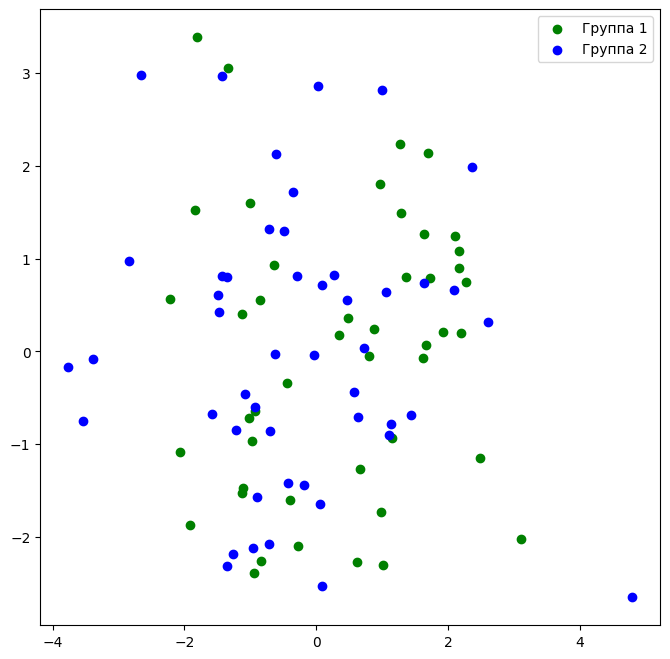

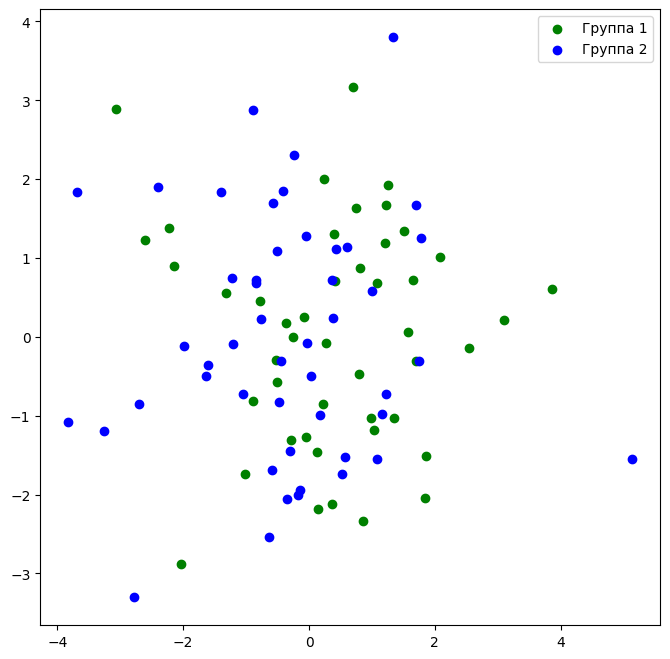

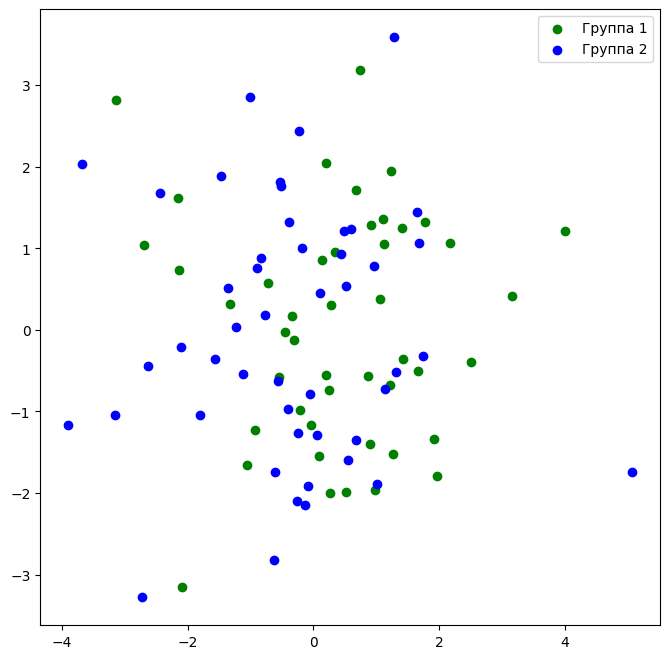

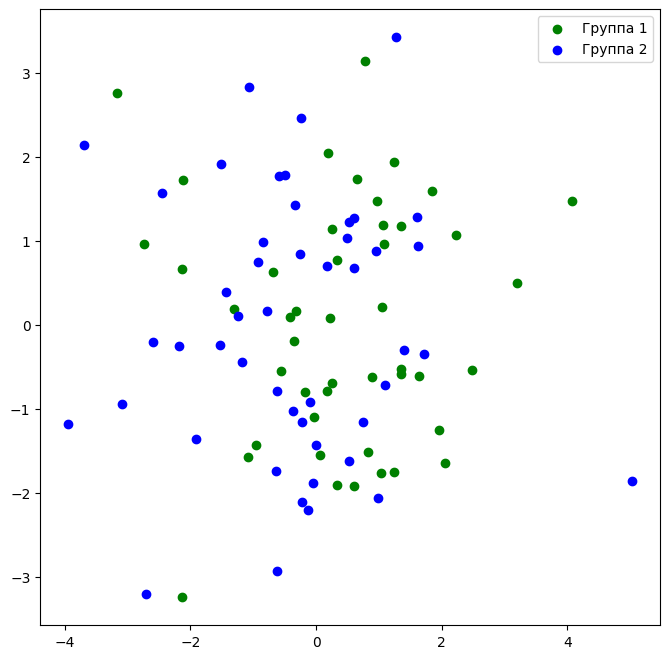

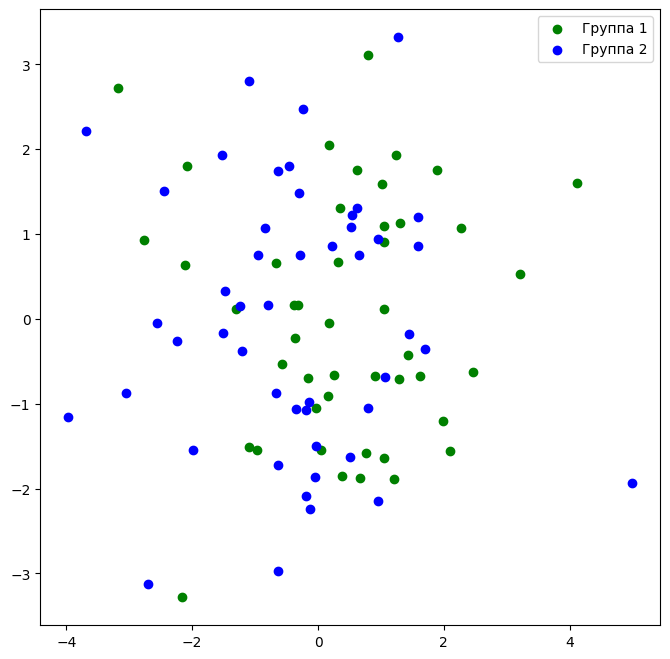

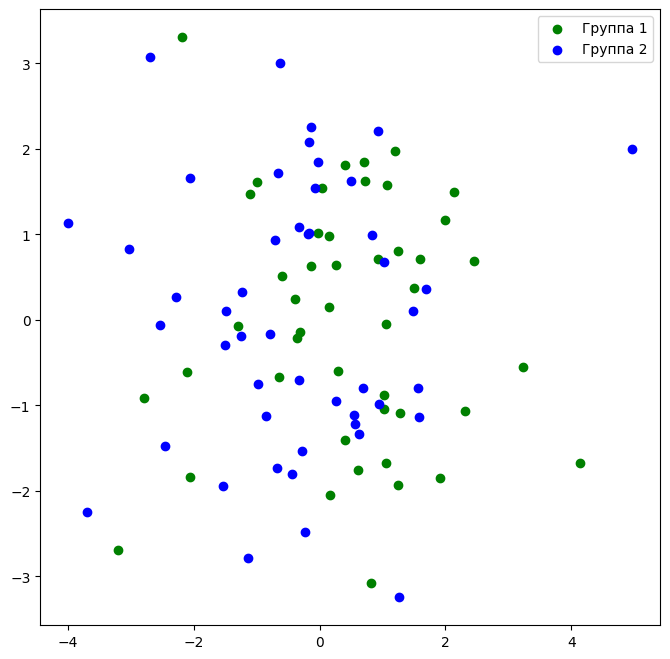

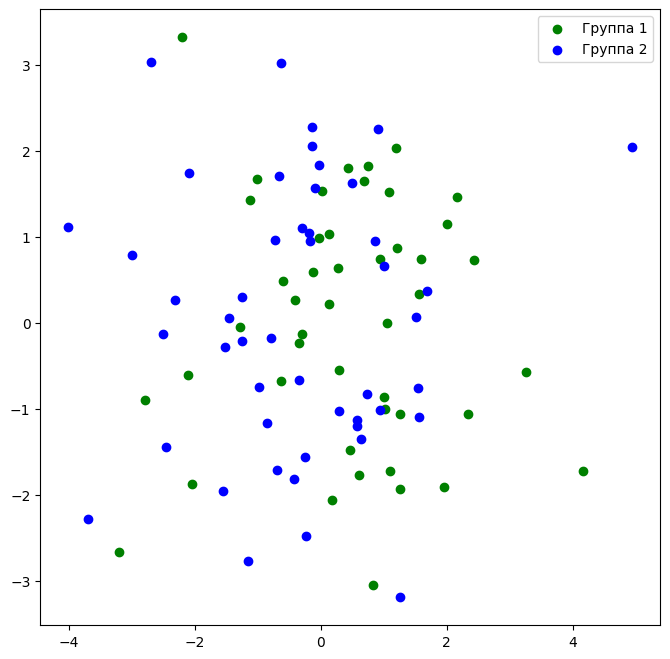

In [21]:
embedding_dim = 32
embedding = nn.Embedding(len(G.nodes()), embedding_dim)

learning_rate = 0.01
optimizer = SGD(embedding.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )
train_label = torch.cat([pos_label, neg_label], dim=0)

train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
epochs = 6000
train(embedding, train_label, train_edge, loss_fn, optimizer, G, g1, epochs=epochs)


#### Вывод: 
после применения алгоритма deepwalk, видно, что группы в графе раззделенеы не четко. Но также видно, что данный метод постепенно сортирует данные группы.

Возможно это связано со сложность графа.

# Node2Vec

In [44]:
from gensim.models import Word2Vec

In [ ]:
def train_word2vec(walks, 
				dimensions=16,
				window_size=5,
				workers=4,
				epochs=1):
    walks = [list(map(str, walk)) for walk in walks] 
    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=epochs,
        negative=10
    )
    return model

In [49]:
def node2vec_walk(G, start_node, walk_length, p, q):
	walk = [start_node]

	while len(walk) < walk_length:
		current_node = walk[-1] # с какой вершины стартуем
		neighbors = list(G.neighbors(current_node))
		if len(neighbors) > 0:
			if len(walk) == 1:
				next_node = random.choice(neighbors)
			else:
				prev_node = walk[-2]
				probabilities = np.ones(len(neighbors))  #  по умолчанию узел, связанный с предыдущим
				for i, neighbor in enumerate(neighbors): 
					if neighbor == prev_node:
						probabilities[i] /= p  # Вероятность возврата
					elif not G.has_edge(prev_node, neighbor):
						probabilities[i] /= q  # Исследование новых узлов
				total = probabilities.sum()
				probabilities /= total
				next_node = random.choices(neighbors, probabilities)[0]
			walk.append(next_node)
		else:
			break
	return walk

def generator_walks(G, num_walks, walk_length, p, q):
    walks = []
    for _ in range(num_walks):
        for node in G.nodes():
            walk = node2vec_walk(G, node, walk_length, p, q)
            walks.append(walk)
    return walks

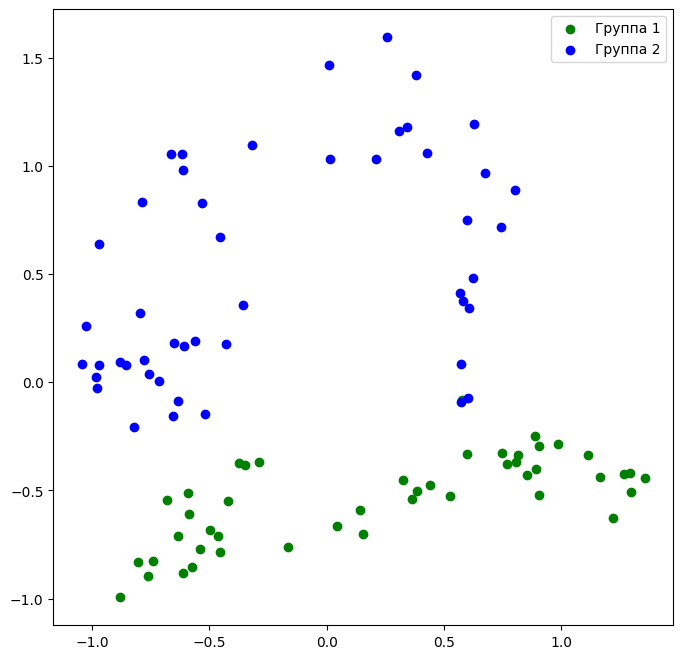

In [50]:
dimensions = 16
walk_length = 15
num_walks = 15
p = 1  # Вероятность возврата
q = 0.5

walks = generator_walks(G, num_walks, walk_length, p, q)
emb_word2vec = train_word2vec(walks, dimensions)
emb_node = np.array([emb_word2vec.wv[str(node)] for node in G.nodes()])

visualize_emb(emb_node, G, g1)

#### Вывод

После применения метода `node2vec` видно как четко выделяются группы. Это связано с улучшенным алгоритмом.

# Обучение классификатора

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [52]:
y = np.array([1 if node in g1 else 0 for node in G.nodes()])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(emb_node, y, test_size=0.25, random_state=42)

In [54]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [55]:
pred = clf.predict(X_test)

In [56]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.91      0.95        11

    accuracy                           0.96        24
   macro avg       0.96      0.95      0.96        24
weighted avg       0.96      0.96      0.96        24



# Доп. Приложение

Попытки из большого социального графа выделить понятный связный подграф

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gitanjali1425/github-social-network-graph-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\89zaz\.cache\kagglehub\datasets\gitanjali1425\github-social-network-graph-dataset\versions\3


In [3]:
df_node = pd.read_csv(Path(path, 'musae_git_edges.csv'))
df_mark_node = pd.read_csv(Path(path, 'musae_git_target.csv'))

In [4]:
def create_graph(df: pd.DataFrame) -> nx.Graph:
    """
    Превращаем df со связами вершин графа в Graph.
    """
    name_col = df.columns
    list_graph = [
        (start_node, end_node) 
        for start_node, end_node in zip(df[name_col[0]], df[name_col[1]])
    ]
    G = nx.Graph(list_graph)
    return G

In [5]:
G = create_graph(df_node)

In [6]:
node_degreese = G.degree()
best_node = max(node_degreese, key=lambda x: x[1])[0]

In [9]:
from tqdm.auto import tqdm
from collections import defaultdict

def find_best_neighbors_graph(G, start_nodes: list[int], node_classes: dict[int: int], num_nodes=100, max_neighbors_count=6):
    node_degreese = G.degree()
    current_nodes = set(start_nodes)
    # Получим соседей для ноды
    current_neighbor_nodes = set().union(
        *[set(G.neighbors(n)) for n in start_nodes]
    )
    current_neighbor_nodes.difference_update(current_nodes)
    # Посчитаем встречаемость каждого класса
    class_labels = set(node_classes.values())
    # Будем считать встречаемость каждого класса
    target_class_counts = {label: np.ceil(num_nodes / len(class_labels)) for label in class_labels}
    current_class_counts = {label: 0 for label in class_labels}
    # Будем вести учет кол-ва соседей для каждой вершины
    current_node_neighbors_count = defaultdict(int)

    for i in tqdm(range(num_nodes - len(start_nodes))):
        skip_current_nodes = set(node for node, count in current_node_neighbors_count.items() if count >= max_neighbors_count)
        # Dыберем наиболее связного с учасниками соседа
        best_node = None
        best_node_neighbors = set()
        best_node_rang = -1
        best_node_vis_neighbors_count = -1
        # Пройдёмся по всем соседям        
        for neighbor_node in current_neighbor_nodes:
            neighbor_node_class = node_classes[neighbor_node]
            neighbor_node_degree = node_degreese[neighbor_node]
            # Если объект класса больше не нужен - пропустим
            if current_class_counts[neighbor_node_class] >= target_class_counts[neighbor_node_class]:
                continue
            # Получим количество связей с существующими учасниками
            node_neighbors = set(G.neighbors(neighbor_node))
            vis_neighbors_count = len(node_neighbors.intersection(current_nodes).difference(skip_current_nodes))
            # Если больше связий, чем у лучшего - заменим
            if best_node is None or \
                (vis_neighbors_count > 1 and vis_neighbors_count > best_node_vis_neighbors_count) or \
                (vis_neighbors_count == best_node_vis_neighbors_count and best_node_rang < neighbor_node_degree):
                best_node = neighbor_node
                best_node_neighbors = node_neighbors
                best_node_rang = neighbor_node_degree
                
            # Если связано с max учасниками - нашли лучшего 
            if vis_neighbors_count == len(current_nodes):
                break
        # Добавим лучшего соседа 
        if best_node is not None:
            current_nodes.add(best_node)
            current_neighbor_nodes.update(best_node_neighbors)
            current_neighbor_nodes.difference_update(current_nodes)
            current_class_counts[node_classes[best_node]] += 1

            best_node_vis_neighbors = best_node_neighbors.intersection(current_nodes)
            current_node_neighbors_count[best_node] += len(best_node_vis_neighbors)
            for node in best_node_neighbors:
                current_node_neighbors_count[node] += 1
        else:
            break

    # Получим подграф, состоящий из выбранных соседей
    target_graph = G.subgraph(current_nodes)

    return target_graph


In [13]:
neighbor_subgraph = find_best_neighbors_graph(G, [best_node], node_classes=df_mark_node['ml_target'].to_dict(), num_nodes=80)

  0%|          | 0/79 [00:00<?, ?it/s]

In [14]:
neighbor_subgraph_colors = ["green" if df_mark_node.iloc[node]['ml_target'] == 0 else "blue" for node in neighbor_subgraph]

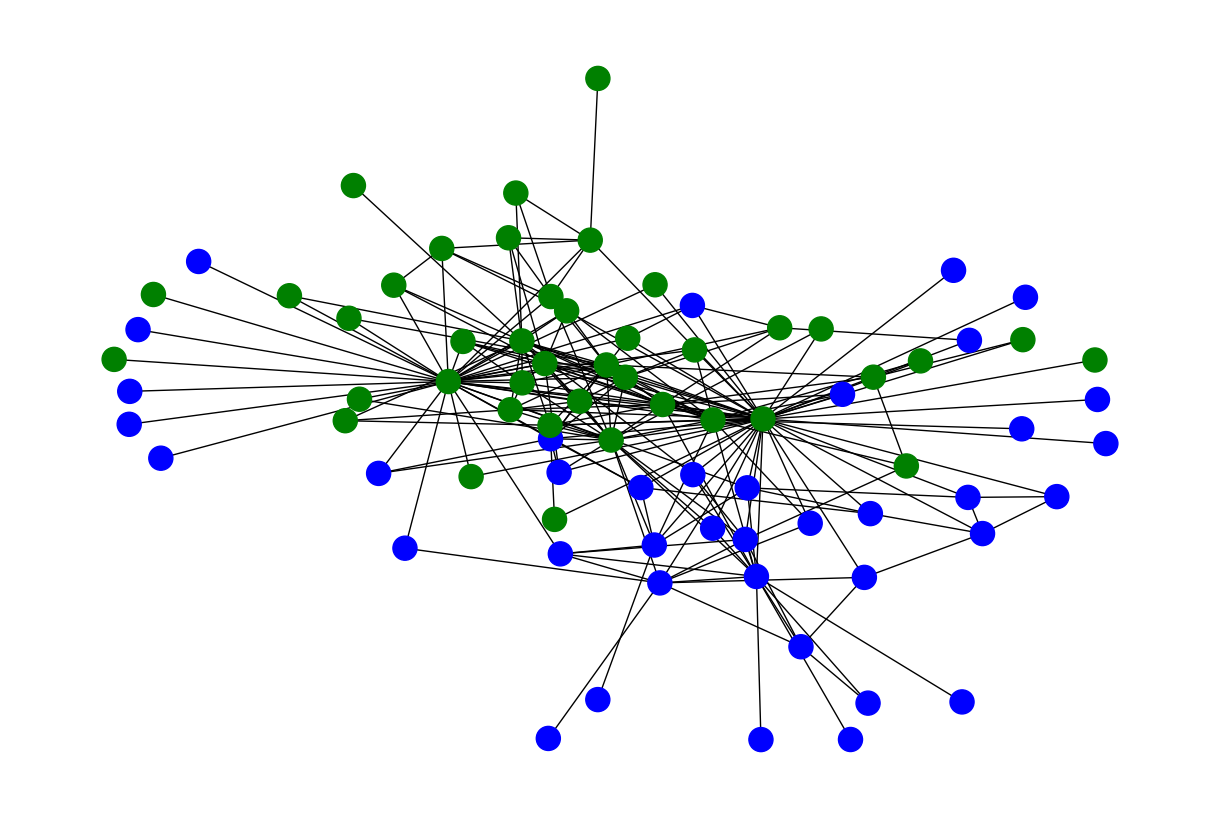

In [15]:
plt.figure(figsize=(12, 8))
nx.draw(neighbor_subgraph, with_labels=False, node_color=neighbor_subgraph_colors)
plt.show()